In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
import pickle

# Using same model as used for Taxi Data

In [67]:
df = pd.read_csv('subway_data_final.csv')

/var/folders/8v/myv9ql5d1lg4ct7vbb0zh8000000gn/T/ipykernel_46851/2244173157.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('subway_data_final.csv')


In [68]:
df.head()

,station_complex_id,latitude,longitude,year,month,day,hour,ridership,busyness_rank
0,8,40.76481,-73.97335,2022,2,0,0,97,5
1,8,40.76481,-73.97335,2022,2,0,1,31,5
2,8,40.76481,-73.97335,2022,2,0,2,8,5
3,8,40.76481,-73.97335,2022,2,0,3,9,5
4,8,40.76481,-73.97335,2022,2,0,4,8,5


In [69]:
df.drop(columns=['ridership'], inplace=True)
df.drop(columns=['latitude'], inplace=True)
df.drop(columns=['longitude'], inplace=True)


**Convert data types**

In [70]:
df.dtypes

station_complex_id    object
year                   int64
month                  int64
day                    int64
hour                   int64
busyness_rank          int64
dtype: object

In [71]:
df['station_complex_id'].unique()

array([8, 9, 10, 13, 14, 16, 17, 20, 22, 103, 107, 118, 119, 143, 144,
       145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 162, 164, 165, 167, 168, 169, 220, 222, 223, 224, 225,
       228, 231, 232, 234, 276, 277, 296, 297, 298, 299, 300, 301, 303,
       304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 316, 318,
       319, 320, 321, 323, 324, 325, 326, 327, 328, 329, 333, 392, 393,
       394, 395, 396, 397, 398, 399, 403, 404, 405, 407, 409, 413, 414,
       436, 437, 438, 439, 440, 441, 471, 475, 476, 477, 601, 602, 605,
       607, 609, 610, 611, 612, 613, 614, 618, 619, 622, 623, 624, 625,
       628, 635, '618', '619', '622', '623', '624', '625', '628', '635',
       '8', '9', 'TRAM1', 'TRAM2'], dtype=object)

In [72]:
df['station_complex_id'] = df['station_complex_id'].astype('category')
# df['latitude'] = df['latitude'].astype('category')
# df['longitude'] = df['longitude'].astype('category')
df['day'] = df['day'].astype('category')
df['hour'] = df['hour'].astype('category')
df['year'] = df['year'].astype('category')
df['month'] = df['hour'].astype('category')

mapping = {'TRAM1': 1, 'TRAM2': 2}

df['station_complex_id'] = df['station_complex_id'].replace(mapping)

# features = ['station_complex_id', 'latitude', 'longitude', 'month', 'day', 'hour', 'year']

/var/folders/8v/myv9ql5d1lg4ct7vbb0zh8000000gn/T/ipykernel_46851/295374491.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['station_complex_id'] = df['station_complex_id'].replace(mapping)


**Split data using a 30% test 70% train split**

In [73]:
df['station_complex_id'].unique()

[8, 9, 10, 13, 14, ..., '635', '8', '9', 1, 2]
Length: 133
Categories (133, object): [8, 9, 10, 13, ..., '8', '9', 1, 2]

In [74]:
X = df.drop(columns=['busyness_rank'])
y = df['busyness_rank']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Define ranks for displaying metrics**

In [75]:
ranks = ['1 (busiest)', '2', '3', '4', '5 (quietest)']

**Evaluation Function**

In [76]:
def evaluate_model(y_test, y_pred):
    """
    Evaluates a classification model and prints key metrics.
    
    Parameters:
    y_test (array-like): True labels
    y_pred (array-like): Predicted labels
    """
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ranks)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title('Confusion Matrix')
    plt.show()
    
    class_report = classification_report(y_test, y_pred, output_dict=True)
    class_report_df = pd.DataFrame(class_report).transpose()

    print("\nClassification Report:")
    print(class_report_df)

# 3. Random Forest
### Original Data

In [77]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [78]:
y_pred_rf = rf.predict(X_test)

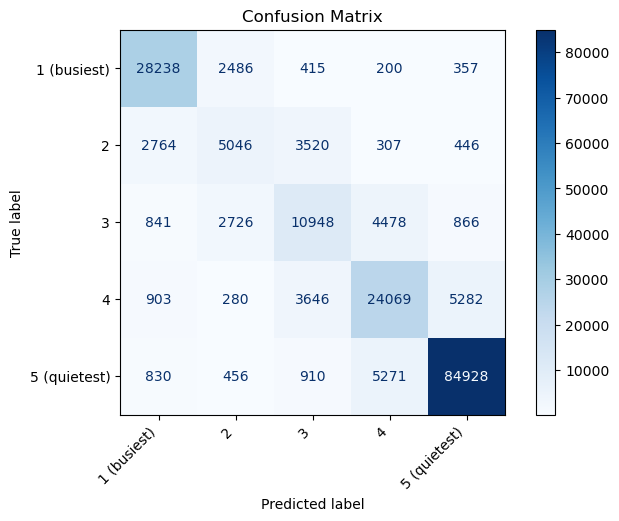


Classification Report:
              precision    recall  f1-score        support
1              0.841017  0.890901  0.865241   31696.000000
2              0.458978  0.417612  0.437319   12083.000000
3              0.563198  0.551287  0.557178   19859.000000
4              0.701209  0.704184  0.702693   34180.000000
5              0.924346  0.919184  0.921758   92395.000000
accuracy       0.805565  0.805565  0.805565       0.805565
macro avg      0.697750  0.696633  0.696838  190213.000000
weighted avg   0.803097  0.805565  0.804139  190213.000000


In [79]:
evaluate_model(y_test, y_pred_rf)

# XGBoost
### Original Data  
**Must be adjusted to represent [0, 1, 2, 3, 4]**

In [80]:
y_adjusted = y - 1
X_train_adjusted, X_test_adjusted, y_train_adjusted, y_test_adjusted = train_test_split(X, y_adjusted, test_size=0.2, random_state=42)

In [81]:
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42, enable_categorical=True)
xgb.fit(X_train_adjusted, y_train_adjusted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

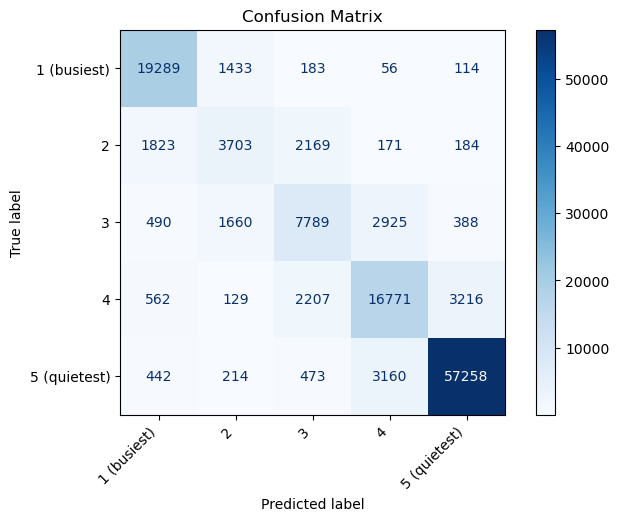


Classification Report:
              precision    recall  f1-score        support
0              0.853269  0.915255  0.883176   21075.000000
1              0.518700  0.460000  0.487590    8050.000000
2              0.607519  0.587760  0.597476   13252.000000
3              0.726552  0.732838  0.729682   22885.000000
4              0.936200  0.930313  0.933247   61547.000000
accuracy       0.826519  0.826519  0.826519       0.826519
macro avg      0.728448  0.725233  0.726234  126809.000000
weighted avg   0.823731  0.826519  0.824808  126809.000000


In [82]:
y_pred_xgb = xgb.predict(X_test_adjusted)

evaluate_model(y_test_adjusted, y_pred_xgb)

# Ensemble (rf, xgboost)

In [83]:
ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft')
ensemble.fit(X_train_adjusted, y_train_adjusted)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 voting='soft')

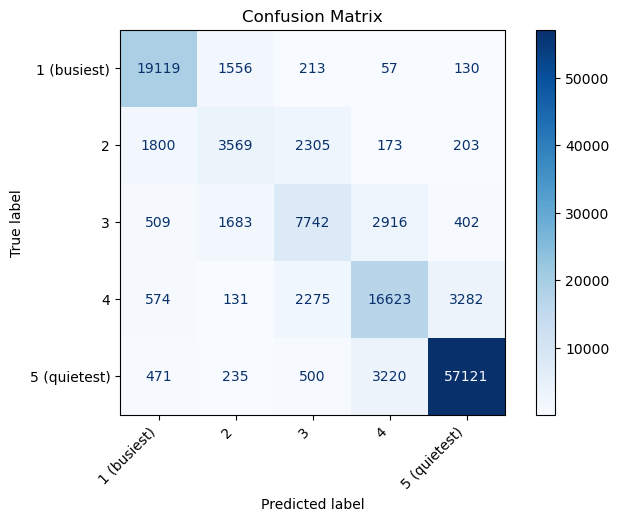


Classification Report:
              precision    recall  f1-score        support
0              0.850754  0.907189  0.878066   21075.000000
1              0.497491  0.443354  0.468865    8050.000000
2              0.593939  0.584214  0.589036   13252.000000
3              0.723085  0.726371  0.724724   22885.000000
4              0.934296  0.928087  0.931181   61547.000000
accuracy       0.821503  0.821503  0.821503       0.821503
macro avg      0.719913  0.717843  0.718375  126809.000000
weighted avg   0.818998  0.821503  0.819991  126809.000000


In [84]:
y_pred_ensemble = ensemble.predict(X_test_adjusted)
evaluate_model(y_test_adjusted, y_pred_ensemble)

# Stacking

In [85]:
base_models = [
    ('rf', rf),
    ('xgb', xgb)
]

meta_model = LogisticRegression()

stacking = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacking.fit(X_train_adjusted, y_train_adjusted)

StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=True,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              im...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=LogisticRegression())

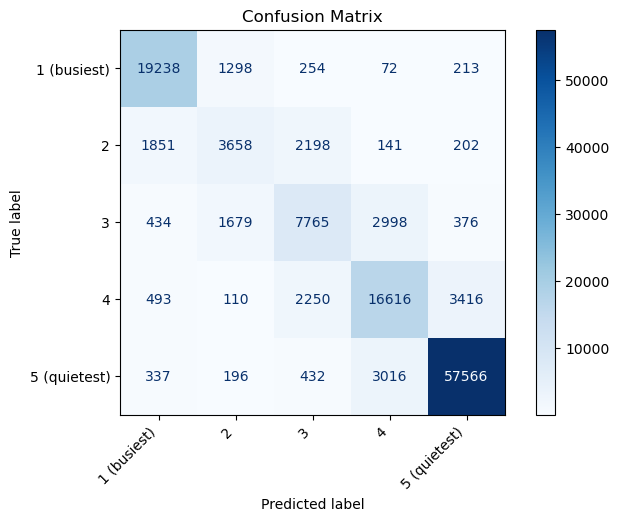


Classification Report:
              precision    recall  f1-score        support
0              0.860645  0.912835  0.885972   21075.000000
1              0.527013  0.454410  0.488026    8050.000000
2              0.601985  0.585949  0.593859   13252.000000
3              0.727400  0.726065  0.726732   22885.000000
4              0.931896  0.935318  0.933604   61547.000000
accuracy       0.826779  0.826779  0.826779       0.826779
macro avg      0.729788  0.722915  0.725639  126809.000000
weighted avg   0.822970  0.826779  0.824563  126809.000000


In [86]:
y_pred_stacking = stacking.predict(X_test_adjusted)

evaluate_model(y_test_adjusted, y_pred_stacking)

In [87]:
with open('subway_stacking_model.pkl', 'wb') as file:
    pickle.dump(stacking, file)